In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import scipy.io as spio
from matplotlib import pylab as plt
from imageio import imread
from anno import *
from part2ind import *

#### Obs: If you only have one of the datasets (does not matter which one), just run all the notebook's cells and it will work just fine.

In [2]:
%cd ..
base_dir = os.getcwd()
# print(cwd)

img_dir = r'PascalVoc2012/train/VOC2012/JPEGImages'
anno_dir = r'PascalVoc2012\train\VOC2012\Annotations_Part_car'
mask_train = r'dataset\masks\train'

d:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3


In [3]:
# # define base paths for pascal augmented VOC images
# # download: http://home.bharathh.info/pubs/codes/SBD/download.html
# base_dataset_dir_aug_voc = '<pascal/augmented/VOC/images/path>/benchmark_RELEASE/dataset'
# images_folder_name_aug_voc = "img/"
# annotations_folder_name_aug_voc = "cls/"
# images_dir_aug_voc = os.path.join(base_dataset_dir_aug_voc, images_folder_name_aug_voc)
# annotations_dir_aug_voc = os.path.join(base_dataset_dir_aug_voc, annotations_folder_name_aug_voc)

In [4]:
def get_files_list(base_dataset_dir, images_folder_name, annotations_folder_name, filename):
    images_dir = os.path.join(base_dataset_dir, images_folder_name)
    annotations_dir = os.path.join(base_dataset_dir, annotations_folder_name)

    file = open(filename, 'r')
    images_filename_list = [line for line in file]
    return images_filename_list

In [5]:
# images_filename_list = get_files_list(base_dataset_dir_aug_voc, images_folder_name_aug_voc, annotations_folder_name_aug_voc, "custom_train.txt")
# print("Total number of training images:", len(images_filename_list))

cwd = os.getcwd()
print(cwd)

d:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3


In [6]:
# shuffle array and separate 10% to validation
path = r'D:/Code/DL_CNN/new/deep-learning-and-convolutional-neural-network/deeplab_v3/PascalVoc2012/train/VOC2012/JPEGImages'
car_files = [os.path.splitext(filename)[0] for filename in os.listdir(path)]
np.random.shuffle(car_files)
val_images_filename_list = car_files[:int(0.10*len(car_files))]
train_images_filename_list = car_files[int(0.10*len(car_files)):]

In [7]:
print("train set size:", len(train_images_filename_list))
print("val set size:", len(val_images_filename_list))
print(train_images_filename_list)

train set size: 609
val set size: 67
['2009_002862', '2008_003300', '2008_002516', '2008_005747', '2008_006082', '2009_004933', '2009_004594', '2009_003212', '2008_006992', '2008_004684', '2010_004690', '2010_002236', '2008_003854', '2008_006336', '2009_001306', '2010_004291', '2008_007432', '2008_004614', '2009_001988', '2008_007573', '2009_004133', '2009_002117', '2009_002058', '2010_004027', '2010_002048', '2009_003566', '2008_005349', '2008_000562', '2010_001274', '2010_003256', '2008_005171', '2008_002834', '2008_003255', '2010_003945', '2008_000187', '2008_007323', '2008_006921', '2010_001732', '2010_004014', '2009_002505', '2008_000315', '2008_002327', '2009_001255', '2008_003943', '2008_003022', '2009_002532', '2009_005060', '2010_000524', '2010_005075', '2010_001110', '2008_005675', '2009_001472', '2010_005414', '2008_006885', '2008_005404', '2008_002442', '2010_004558', '2010_000493', '2008_004876', '2010_004569', '2008_002118', '2008_006272', '2010_005672', '2009_001481', '2

In [8]:
TRAIN_DATASET_DIR="./tfrecords/"
if not os.path.exists(TRAIN_DATASET_DIR):
    os.mkdir(TRAIN_DATASET_DIR)
    
TRAIN_FILE = 'train.tfrecords'
VALIDATION_FILE = 'validation.tfrecords'
train_writer = tf.io.TFRecordWriter(os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE))
val_writer = tf.io.TFRecordWriter(os.path.join(TRAIN_DATASET_DIR,VALIDATION_FILE))

In [9]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [10]:
import numpy as np
from scipy.io import loadmat
from skimage.io import imread
from skimage.measure import regionprops
from part2ind import get_pimap


PIMAP = get_pimap()


class ImageAnnotation(object):
    def __init__(self, impath, annopath):
        # read image
        self.im = imread(impath)
        self.impath = impath
        self.imsize = self.im.shape

        # read annotations
        data = loadmat(annopath)['anno'][0, 0]
        self.imname = data['imname'][0]
        self.annopath = annopath

        # parse objects and parts
        self.n_objects = data['objects'].shape[1]
        self.objects = []
        for obj in data['objects'][0, :]:
            self.objects.append(PascalObject(obj))

        # create masks for objects and parts
        self._mat2map()

    def _mat2map(self):
        ''' Create masks from the annotations
        Python implementation based on
        http://www.stat.ucla.edu/~xianjie.chen/pascal_part_dataset/trainval.tar.gz

        Read the annotation and present it in terms of 3 segmentation mask maps (
        i.e., the class maks, instance maks and part mask). pimap defines a
        mapping between part name and index (See part2ind.py).
        '''
        shape = self.imsize[:-1]  # first two dimensions, ignore color channel
        self.cls_mask = np.zeros(shape, dtype=np.uint8)
        self.inst_mask = np.zeros(shape, dtype=np.uint8)
        self.part_mask = np.zeros(shape, dtype=np.uint8)
        for i, obj in enumerate(self.objects):
            class_ind = obj.class_ind
            mask = obj.mask

            self.inst_mask[mask > 0] = i + 1
            self.cls_mask[mask > 0] = class_ind

            if obj.n_parts > 0:
                for p in obj.parts:
                    part_name = p.part_name
                    pid = PIMAP[class_ind][part_name]
                    self.part_mask[p.mask > 0] = pid


class PascalBase(object):
    def __init__(self, obj):
        self.mask = obj['mask']
        self.props = self._get_region_props()

    def _get_region_props(self):
        ''' useful properties
        It includes: area, bbox, bbox_Area, centroid
        It can also extract: filled_image, image, intensity_image, local_centroid
        '''
        return regionprops(self.mask)[0]


class PascalObject(PascalBase):
    def __init__(self, obj):
        super(PascalObject, self).__init__(obj)

        self.class_name = obj['class'][0]
        self.class_ind = obj['class_ind'][0, 0]

        self.n_parts = obj['parts'].shape[1]
        self.parts = []
        if self.n_parts > 0:
            for part in obj['parts'][0, :]:
                self.parts.append(PascalPart(part))


class PascalPart(PascalBase):
    def __init__(self, obj):
        super(PascalPart, self).__init__(obj)
        self.part_name = obj['part_name'][0]


In [11]:
"""
Adapted from: https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae

Python implementation of the color map function for the PASCAL VOC data set.
Official Matlab version can be found in the PASCAL VOC devkit
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit
"""
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
from matplotlib.colors import LinearSegmentedColormap


def color_map(N=256, normalized=True, matplotlib=True):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    if matplotlib:
        assert(normalized is True)
        return LinearSegmentedColormap.from_list('VOClabel_cmap', cmap)
    else:
        return cmap


def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
              'bottle', 'bus', 'car', 'cat', 'chair',
              'cow', 'diningtable', 'dog', 'horse', 'motorbike',
              'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()


7
car
rightside
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 

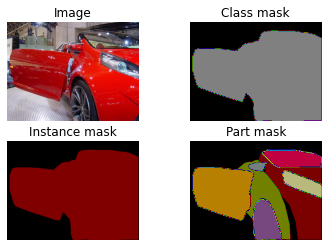

In [19]:
from anno import ImageAnnotation, PascalBase, PascalObject, PascalPart
np.set_printoptions(threshold=sys.maxsize)
fdir = ''
fname_anno = annodir + r'\2008_000027.mat'
fname_im = imgdir + r'\2008_000027.jpg'

an = ImageAnnotation(fname_im,fname_anno)


# an1 = PascalBase(an.objects[0].class_name)
# for i in an.n_objects:
#     print(an.objects[i].parts)
# print(an.objects[0].mask)
print(an.objects[0].n_parts)
print(an.objects[0].class_name)
print(an.objects[0].parts[1].part_name)
print(an.objects[0].parts[1].mask)
# print(an.objects[0].props.b)
# print(an.inst_mask)
# print(an.part_mask[0])
# print(an.n_objects)
# print(an.imsize[0])


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(an.im)
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(an.cls_mask, cmap=color_map(N=np.max(an.cls_mask) + 1))
ax2.set_title('Class mask')
ax2.axis('off')
ax3.imshow(an.inst_mask, cmap=color_map(N=np.max(an.inst_mask) + 1))
ax3.set_title('Instance mask')
ax3.axis('off')
if np.max(an.part_mask) == 0:
    ax4.imshow(an.part_mask, cmap='gray')
else:
    ax4.imshow(an.part_mask, cmap=color_map(N=np.max(an.part_mask) + 1))
ax4.set_title('Part mask')
ax4.axis('off')
plt.show()


In [17]:
def read_annotation_from_mat_file(annotations_dir, image_name):
    annodir = r'D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\PascalVoc2012\train\VOC2012\Annotations_Part_car'
    imgdir = r'D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\PascalVoc2012\train\VOC2012\JPEGImages'
    
    annotations_path = os.path.join(annodir, (image_name.strip() + ".mat"))
    mat = spio.loadmat(annotations_path)
    an = ImageAnnotation(
        os.path.join(imgdir, image_name + '.jpg'),
        os.path.join(annodir, annotations_path))
    
    return an

In [18]:

annodir = r'D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\PascalVoc2012\train\VOC2012\Annotations_Part_car'
imgdir = r'D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\PascalVoc2012\train\VOC2012\JPEGImages'
def make_dict(filename_list, imgset):
    d = {}
    for i, image_name in enumerate(filename_list):      # gets image names and iterates through 
        an = read_annotation_from_mat_file(annodir, image_name)
        d[i] = {}
        d[i]['img_name'] = image_name
        fname = image_name[:11]
        f = open(image_name + ".json", "w")
        # d[i]['img_rgb'] = an.im
        # print(d[i]['img_rgb'])
        d[i]['img_size'] = an.imsize
        d[i]['annopath'] = an.annopath
        d[i]['num_obj'] = an.n_objects
        for obj in range(an.n_objects):
            d[i][obj] = {}
            d[i][obj]['objects'] = an.objects[obj].class_name
            d[i][obj]['obj_bbox'] = an.objects[obj].props.bbox
            # d[i][obj]['cls_mask'] = an.objects[obj].mask
            # plt.imsave(fname + an.objects[obj].class_name + '.png', an.objects[obj].mask)
            for parts in range(an.objects[obj].n_parts):
                d[i][obj][parts] = {}
                d[i][obj][parts]['parts'] = an.objects[obj].parts[parts].part_name
                d[i][obj][parts]['part_bbox'] = an.objects[obj].parts[parts].props.bbox
                # d[i][obj][parts]['part_mask'] = an.objects[obj].parts[parts].mask
                # plt.imsave(fname + an.objects[obj].class_name + an.objects[obj].parts[parts].part_name + '.png', an.objects[obj].parts[parts].mask)
                if (imgset == 'test'):
                    %cd D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\test
                    with open(image_name + '.json', 'w', encoding='utf-8') as f:
                        json.dump(d[i], f, ensure_ascii=False, indent=4)
                else:
                    %cd D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
                    with open(image_name + '.json', 'w', encoding='utf-8') as f:
                        json.dump(d[i], f, ensure_ascii=False, indent=4)
    return d

In [81]:
%cd D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\masks\train

D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\masks\train


In [82]:
from flatten_dict import flatten
import json
%cd D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\masks\train
train_dict = make_dict(train_images_filename_list, 'train')
%cd D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\masks\test
test_dict = make_dict(val_images_filename_list, 'test')
# print(dict[1][0])
# print(json.dumps(dict[1]))
# print(flatten(dict))
# print(type(dict[1]['img_rgb']))
# img = dict[1]['img_rgb']
# type(an.im)
# print(an.im.tobytes())

D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\masks\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learning-and-convolutional-neural-network\deeplab_v3\dataset\annos\train
D:\Code\DL_CNN\new\deep-learni

In [43]:
from schema import *
from flatten_dict import flatten
import json
def create_tfrecord_dataset(filename_list, writer):
    # create training tfrecord
    read_imgs_counter = 0
    annodir = r"PascalVoc2012\train\VOC2012\Annotations_Part_car"
    imgdir = r'PascalVoc2012\train\VOC2012\JPEGImages'


    for i, image_name in enumerate(filename_list):
        image_name = "\\" + image_name
        image_name.replace(" ", "") 
        # print(i)
        try:
            image_np = cv2.imread(os.path.join(images_dir_aug_voc, image_name.strip() + ".jpg"))
        except FileNotFoundError:
            try:
                # read from Pascal VOC path
                an = read_annotation_from_mat_file(annodir, image_name)
                image_np = an.im
                image_h = an.imsize[0]
                image_w = an.imsize[1]
                        # image_w = an.imsize[1]

                img_raw = image_np.tostring()
                # cv2.imread(path + images_folder_name_voc + image_name + ".jpg")
            except FileNotFoundError as not_found:
                print("File:",image_name.strip(),"not found. 1")
                print(image_name)
                print(path + images_folder_name_voc + image_name)
                
                continue
        try:
            dict = make_dict(train_images_filename_list)
        except FileNotFoundError:
            # read from Pascal VOC path
            try:
                annotation_np = read_annotation_from_mat_file(annodir, image_name)
            except FileNotFoundError:
                print("File:",image_name.strip(),"not found. 2")
                print(annodir.replace(" ", ""),image_name.replace(" ", ""))
                continue
        read_imgs_counter += 1
        print(read_imgs_counter)
        img_size = dict[i]['img_size']
        image_h = img_size[0]
        image_w = img_size[1]
        # image_name = image_name.tostring()
        img_raw = dict[i]['img_rgb']
        # img_raw = img_raw.tostring()

        # annotation_raw = flatten(dict)
        # annotation_raw = json.dumps(dict).encode('utf-8')
        s = str(flatten(dict))
        # b = s.encode('utf-8')
        
        
        

        

        example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(image_h),
                'width': _int64_feature(image_w),
                'image_raw': _bytes_feature(img_raw),
                'annotation_raw': _bytes_feature(s)
                }))

        writer.write(example.SerializeToString())
    
    print("End of TfRecord. Total of image written:", read_imgs_counter)
    writer.close()

In [44]:
# create training dataset
# create_tfrecord_dataset(train_images_filename_list, train_writer)

In [45]:
os.listdir('D:/Code/DL_CNN/new/deep-learning-and-convolutional-neural-network/deeplab_v3/PascalVoc2012/train/VOC2012/JPEGImages')

['2008_000027.jpg',
 '2008_000028.jpg',
 '2008_000042.jpg',
 '2008_000050.jpg',
 '2008_000074.jpg',
 '2008_000085.jpg',
 '2008_000105.jpg',
 '2008_000133.jpg',
 '2008_000143.jpg',
 '2008_000163.jpg',
 '2008_000174.jpg',
 '2008_000176.jpg',
 '2008_000185.jpg',
 '2008_000187.jpg',
 '2008_000189.jpg',
 '2008_000193.jpg',
 '2008_000199.jpg',
 '2008_000252.jpg',
 '2008_000253.jpg',
 '2008_000304.jpg',
 '2008_000315.jpg',
 '2008_000346.jpg',
 '2008_000356.jpg',
 '2008_000399.jpg',
 '2008_000457.jpg',
 '2008_000488.jpg',
 '2008_000501.jpg',
 '2008_000562.jpg',
 '2008_000563.jpg',
 '2008_000595.jpg',
 '2008_000659.jpg',
 '2008_000719.jpg',
 '2008_000884.jpg',
 '2008_000952.jpg',
 '2008_001018.jpg',
 '2008_001039.jpg',
 '2008_001042.jpg',
 '2008_001169.jpg',
 '2008_001208.jpg',
 '2008_001262.jpg',
 '2008_001274.jpg',
 '2008_001334.jpg',
 '2008_001359.jpg',
 '2008_001375.jpg',
 '2008_001440.jpg',
 '2008_001445.jpg',
 '2008_001446.jpg',
 '2008_001500.jpg',
 '2008_001533.jpg',
 '2008_001543.jpg',


In [46]:
# create validation dataset
# create_tfrecord_dataset(val_images_filename_list, val_writer)